In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from numf.peaks import get_neighbors
import matplotlib.pyplot as plt
from numf.utils import initialize_matrices
from numf.numf import numf
from scipy.interpolate import interp1d

## Reducing area under W

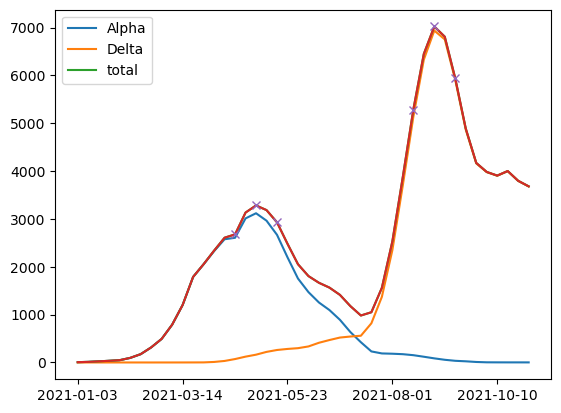

In [2]:
df = pd.read_csv(f'../data/canada_variant_weekly_4w_avg.csv', index_col=0)
xdf = df.loc['2021-01-01': '2021-11-01', ['Alpha', 'Delta']]
xdf['total'] = xdf.sum(axis=1)
xdf.plot()

M0 = xdf['total'].to_numpy().reshape(-1, 1)
m, n = M0.shape
r = 2

peaks, _ = find_peaks(x=M0.reshape(m, ), prominence=1, width=3)
pvals = get_neighbors(peaks, m, nrad=2)

plt.plot(M0)
plt.plot(pvals, M0[pvals], 'x')

In [3]:
W0, H0 = initialize_matrices(m, n, r)
iters = 5000
W1, H1, pouts1 = numf(M0, W0.copy(), H0.copy(), pvals=pvals, iters=iters, verbose=False)

In [4]:
W2, H2, pouts2 = numf(M0, W0.copy(), H0.copy(), pvals=pvals, beta=0.1, iters=iters, verbose=False)

Text(0.5, 1.0, 'NuMF with area minimization')

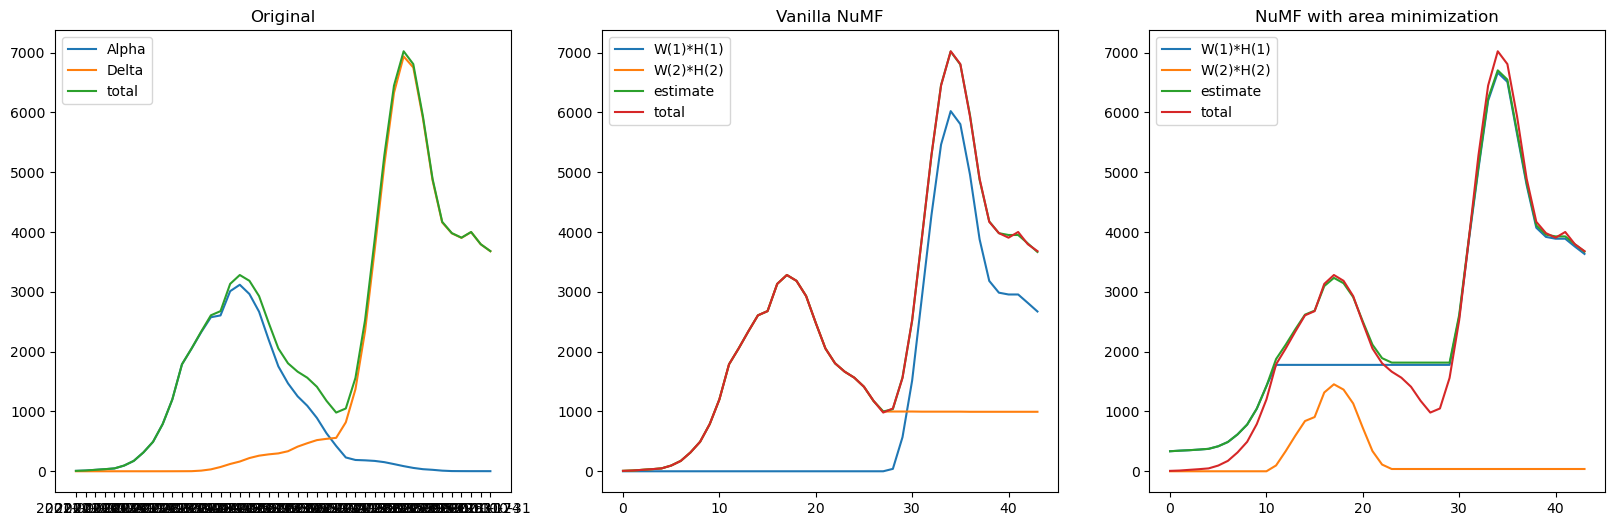

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(xdf['Alpha'])
axs[0].plot(xdf['Delta'])
axs[0].plot(xdf['total'])
axs[0].legend(['Alpha', 'Delta', 'total'])
axs[0].set_title('Original')


for i in range(r):
    axs[1].plot(W1[:, i] * H1[i, :])
axs[1].plot(W1 @ H1)
axs[1].plot(M0)
axs[1].legend(['W(1)*H(1)', 'W(2)*H(2)', 'estimate','total'])
axs[1].set_title('Vanilla NuMF')

for i in range(r):
    axs[2].plot(W2[:, i] * H2[i, :])
axs[2].plot(W2 @ H2)
axs[2].plot(M0)
axs[2].legend(['W(1)*H(1)', 'W(2)*H(2)', 'estimate','total'])
axs[2].set_title('NuMF with area minimization')

## Disjoint & Extrapolation

In [6]:
def interp_nans(y, x=None):
    if x is None:
        x = np.arange(len(y))
    nans = np.isnan(y)

    interpolator = interp1d(
        x[~nans],
        y[~nans],
        kind="linear",
        fill_value="extrapolate",
        assume_sorted=True,
    )
    return interpolator(x)

In [7]:
threshold = min(M0[peaks[0]: peaks[1]])
M1 = M0 - threshold
M1[M1 < 0] = 0
# plt.plot(M1)
# threshold_idx = peaks[0] + np.argmin(M0[peaks[0]: peaks[1]])
# plt.plot(threshold_idx, M1[threshold_idx], 'x')

In [8]:
W3, H3, pouts3 = numf(M1, W0.copy(), H0.copy(), pvals=pvals, iters=iters, verbose=False)

In [9]:
# for i in range(r):
#     plt.plot(W3[:, i] * H3[i, :])
# plt.plot(M0)

Text(0.5, 1.0, 'Disjoint NuMF and linear extrapolation')

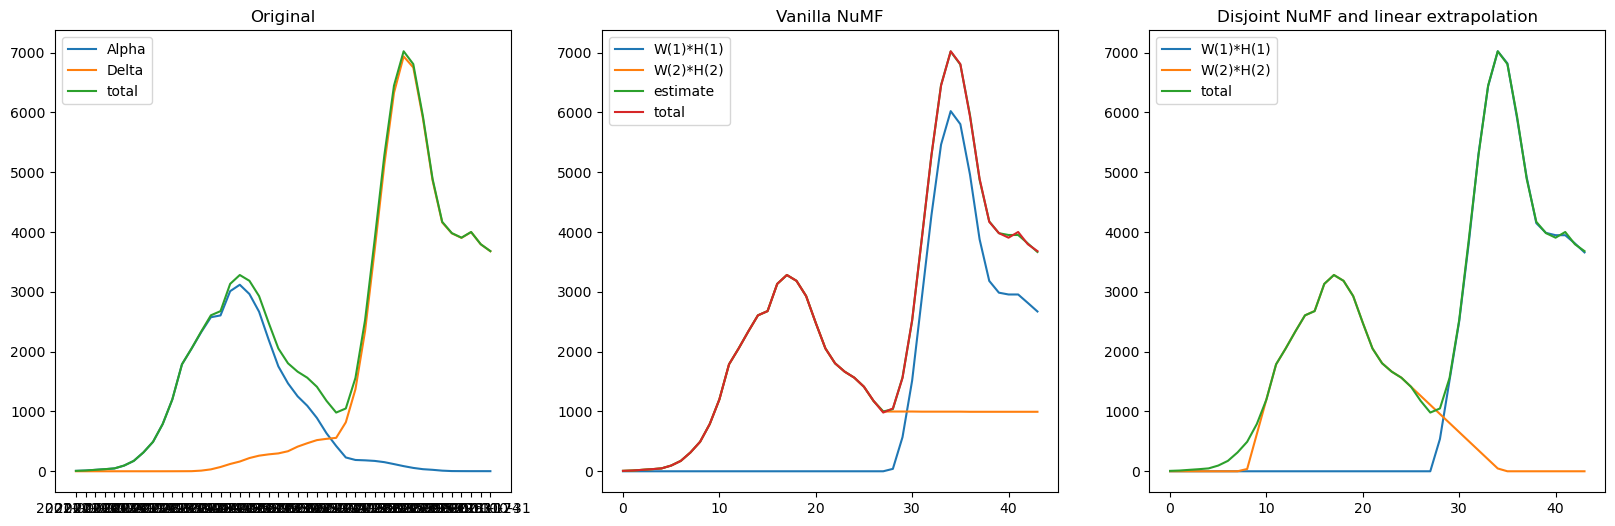

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(xdf['Alpha'])
axs[0].plot(xdf['Delta'])
axs[0].plot(xdf['total'])
axs[0].legend(['Alpha', 'Delta', 'total'])
axs[0].set_title('Original')


for i in range(r):
    axs[1].plot(W1[:, i] * H1[i, :])
axs[1].plot(W1 @ H1)
axs[1].plot(M0)
axs[1].legend(['W(1)*H(1)', 'W(2)*H(2)', 'estimate','total'])
axs[1].set_title('Vanilla NuMF')

for i in range(r):
    tmp = W3[:, i] * H3[i, :]
    xthres = 200
    arr = tmp > xthres
    tmp[arr] = tmp[arr] + threshold
    tmp[~arr] = np.NaN

    new_tmp = interp_nans(tmp)
    new_tmp[new_tmp <= 0] = 0
    axs[2].plot(new_tmp)
# axs[2].plot(W3 @ H3)
axs[2].plot(M0)
axs[2].legend(['W(1)*H(1)', 'W(2)*H(2)','total'])
axs[2].set_title('Disjoint NuMF and linear extrapolation')


## Does using hospitalizations improve results?

In [11]:
df2 = pd.read_csv('../data/owid-covid-data.csv', index_col=0)
df_can = df2[df2['location'] == 'Canada']
df_can.reset_index(inplace=True)
# df_can.head()

In [12]:
df_can = df_can[['date', 'new_cases', 'hosp_patients']]
df_can['date'] = pd.to_datetime(df_can['date'])

# removing NaN values
df_can = df_can[~df_can.isna().any(axis=1)]
# df_can.head()

<AxesSubplot:xlabel='date'>

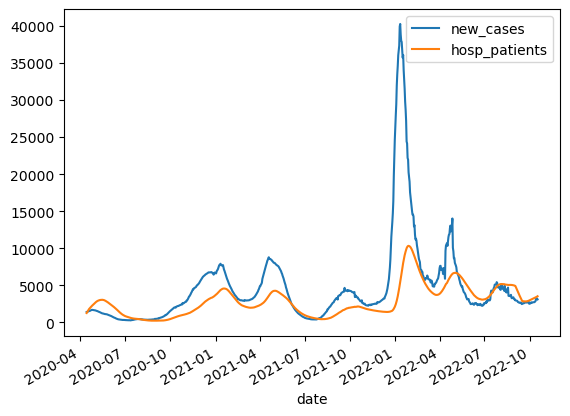

In [13]:
df_can['new_cases'] = df_can['new_cases'].rolling(window=14).mean()
df_can['hosp_patients'] = df_can['hosp_patients'].rolling(window=14).mean()
df_can = df_can[~df_can.isna().any(axis=1)]
df_can.set_index('date', inplace=True)
df_can.plot()

In [14]:
# df_can.loc['2020-08-01': '2021-08-01', :].plot()

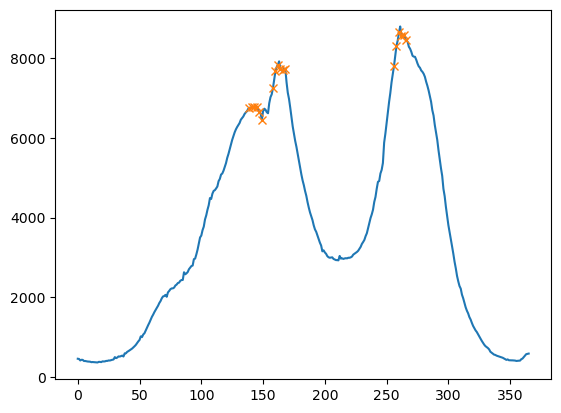

In [15]:
## without hosp
M1d = df_can.loc['2020-08-01': '2021-08-01', 'new_cases'].to_numpy().reshape(-1, 1)
m, n = M1d.shape

peaks, _ = find_peaks(x=M1d.reshape(m, ), prominence=1, width=3)
pvals = get_neighbors(peaks, m, nrad=5)

plt.plot(M1d)
plt.plot(pvals, M1d[pvals], 'x')

In [16]:
r = 6
iters = 500

W0, H0 = initialize_matrices(m, n, r)
W1, H1, pouts1 = numf(M1d, W0.copy(), H0.copy(), pvals=pvals, iters=iters)

Loss: 0.34565903335388704
Loss: 0.20999858805284743
Loss: 0.1835195732931629
Loss: 0.1610722338460435
Loss: 0.14553385502757762
Loss: 0.13466235817221886
Loss: 0.12085665781583467
Loss: 0.10091361233570088
Loss: 0.09316249866224625
Loss: 0.08726865424790646
Loss: 0.08265758343179759
Loss: 0.0787899234010268
Loss: 0.0754826019781556
Loss: 0.07261020927607875
Loss: 0.07007223038460796
Loss: 0.06779284491882127
Loss: 0.06571658438697499
Loss: 0.06380702074045101
Loss: 0.06203853126109275
Loss: 0.060389046676833355
Loss: 0.058842994962629014
Loss: 0.05738809350395627
Loss: 0.056015578576929376
Loss: 0.054719866332832726
Loss: 0.053492776581521774
Loss: 0.05232935481196589
Loss: 0.05122277974173779
Loss: 0.05016956324857528
Loss: 0.04916503495583355
Loss: 0.048206464900902385
Loss: 0.04729074425671331
Loss: 0.04641391527546101
Loss: 0.04557395547098044
Loss: 0.04476941306904443
Loss: 0.04399700985966414
Loss: 0.04325506234181743
Loss: 0.042542540413577766
Loss: 0.041856961278069114
Loss: 0.

In [17]:
M2d = df_can.loc['2020-08-01': '2021-08-01', :].to_numpy()
m, n = M2d.shape

peaks1, _ = find_peaks(x=M2d[:, 0].reshape(m, ), prominence=1, width=3)
peaks2, _ = find_peaks(x=M2d[:, 1].reshape(m, ), prominence=1, width=3)
xpvals = get_neighbors(np.append(peaks1, peaks2), m, nrad=5)
#
# plt.plot(M2)
# plt.plot(pvals, M2[pvals], 'x')

In [18]:
W0, H0 = initialize_matrices(m, n, r)
W2, H2, pouts2 = numf(M2d, W0.copy(), H0.copy(), pvals=xpvals, iters=iters)

Loss: 0.429138522924136
Loss: 0.22365772824708446
Loss: 0.2017518959212162
Loss: 0.18822133824504006
Loss: 0.17825051070093542
Loss: 0.17029172489673683
Loss: 0.16349913290548218
Loss: 0.1578668594802851
Loss: 0.15293532412036628
Loss: 0.14839925565314652
Loss: 0.14424948785614342
Loss: 0.14044860036995066
Loss: 0.1368317493867845
Loss: 0.13344551698078042
Loss: 0.13027987730367974
Loss: 0.12723605752275155
Loss: 0.1243681491515856
Loss: 0.12167135575580691
Loss: 0.11910997367451956
Loss: 0.11670222823008226
Loss: 0.11443090167353626
Loss: 0.11223824772420718
Loss: 0.11014844873445433
Loss: 0.1081709477432325
Loss: 0.10625117395458779
Loss: 0.10440184371717355
Loss: 0.10264952292731853
Loss: 0.10093909155408838
Loss: 0.09928312708566299
Loss: 0.09768049014236234
Loss: 0.09612305199845309
Loss: 0.09461307152407289
Loss: 0.09312125345256973
Loss: 0.09169169729040416
Loss: 0.09026661296093572
Loss: 0.08889572732271406
Loss: 0.08753161209266182
Loss: 0.08621032269550635
Loss: 0.08489899372

Text(0.5, 1.0, 'With hospitalizations')

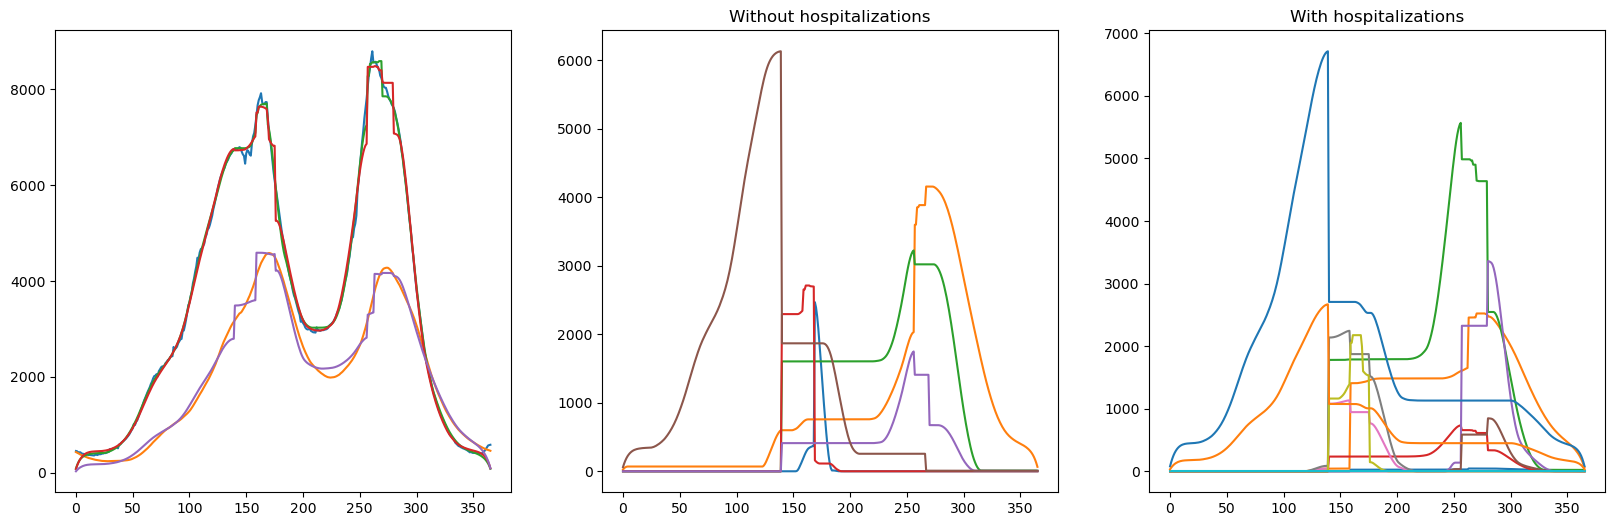

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(M2d)
axs[0].plot(W1 @ H1)
axs[0].plot(W2 @ H2)

for i in range(W1.shape[1]):
    axs[1].plot(W1[:, i] * H1[i, :])
    axs[2].plot(W2[:, i].reshape(m, 1) @ H2[i, :].reshape(1, n))
axs[1].set_title('Without hospitalizations')
axs[2].set_title('With hospitalizations')